In [15]:
import numpy as np
import xarray as xr
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import areamean_dhq as areamean
import copy
import dyl_function_slope as dyl
import cmaps
sequence_font={
    'style': "Arial",
    'weight': "bold",
    'fontsize':7
}
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.figsize'] = (6, 6)
ccmap = cmaps.cmp_b2r

# 定义函数

In [16]:
def calculate_zonal_stats(data):
    # Assuming 'data' is a 2D array with shape (lat, lon)
    zonal_mean = np.nanmean(data, axis=1)  # Zonal mean
    zonal_std = np.nanstd(data, axis=1)  # Zonal standard deviation
    return zonal_mean, zonal_std

In [17]:
# 绘制观测趋势图并添加显著性阴影
def plot_trend_and_significance(axes, data, trend, p_values, title, sequence, exp, levels, levels2, ccmap, climatology=None,hzl=False):
    # Set the global extent
    # ax.projection(ccrs.Robinson())
    time, lat, lon = data.dims
    ax = fig.add_axes(axes, projection=ccrs.Robinson())
    ax.set_global()
    ax.set_aspect(1.25)

    if hzl:
        # ======= 添加20-40°N紫色横线 =======
        for lats in [20, 40]:
            ax.plot([-180, 180], [lats, lats], color='magenta', linewidth=1.2, linestyle='-',
                    transform=ccrs.PlateCarree(), zorder=4,alpha=0.8)

    # 为数据添加周期性点
    trend_cyclic, lon_cyclic = add_cyclic_point(trend, coord=data[lon])
    # 确保一致性掩码也添加周期性点
    consistency_mask_cyclic, _ = add_cyclic_point(p_values, coord=data[lon])

    # Plot the trend
    cf = ax.contourf(lon_cyclic, data[lat], trend_cyclic, levels=levels, cmap=ccmap, extend='both',
                     transform=ccrs.PlateCarree())
    ax.coastlines(lw=0.5)

    # Add gridlines and labels
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels = False
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

    # Plot the significance
    significance = np.ma.masked_where(p_values >= 0.05, p_values)
    cc = ax.contourf(data[lon], data[lat], significance, hatches=['...'], colors='none', transform=ccrs.PlateCarree())
    if hasattr(cc, 'collections'):
        collections = cc.collections
    else:
        collections = [cc]
    # 设置 hatch 样式
    for collection in collections:
        collection.set_edgecolor('grey')
        collection.set_linewidth(0)

    if climatology:
        clim_cyclic, _ = add_cyclic_point(climatology, coord=data[lon])
        c2 = ax.contour(lon_cyclic, data[lat], clim_cyclic, levels=levels2, colors='m', alpha=0.9, linewidths=.5,
                        transform=ccrs.PlateCarree())
        ax.clabel(c2, colors='k', inline=True, fontsize=5)
    # Set the title
    #ax.set_title(title, fontsize=7)
    ax.text(-0.1, 1.1, sequence, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')
    ax.text(0.7, 1.1, exp, transform=ax.transAxes, fontsize=7, va='top', ha='left')

    return cf


In [18]:
# 绘制模式的趋势图并添加显著性阴影
def plot_trend_and_significance_ssp(axes, data, trend, p_values, title, sequence, exp, levels, levels2,
                                    ccmap, climatology=None, hzl=False):
    ax = fig.add_axes(axes, projection=ccrs.Robinson())
    ax.set_global()
    ax.set_aspect(1.25)

    if hzl:
        # ======= 添加20-40°N紫色横线 =======
        for lats in [20, 40]:
            ax.plot([-180, 180], [lats, lats], color='magenta', linewidth=1.2, linestyle='-',
                    transform=ccrs.PlateCarree(), zorder=4,alpha=0.8)
    # 为数据添加周期性点
    trend_cyclic, lon_cyclic = add_cyclic_point(trend, coord=data['lon'])
    # 确保一致性掩码也添加周期性点
    consistency_mask_cyclic, _ = add_cyclic_point(p_values, coord=data['lon'])
    # Plot the trend
    cf = ax.contourf(lon_cyclic, data['lat'], trend_cyclic, levels=levels, cmap=ccmap, extend='both',
                     transform=ccrs.PlateCarree())
    ax.coastlines(lw=0.5)
    # Add gridlines and labels
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels = False
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}
    # Plot the significance
    significance = np.ma.masked_where(p_values >= 0.05, p_values)
    cc = ax.contourf(data['lon'], data['lat'], significance, hatches=['...'], colors='none',
                     transform=ccrs.PlateCarree())

    if hasattr(cc, 'collections'):
        collections = cc.collections
    else:
        collections = [cc]
    # 设置 hatch 样式
    for collection in collections:
        collection.set_edgecolor('grey')
        collection.set_linewidth(0)

    if climatology:
        clim_cyclic, _ = add_cyclic_point(climatology, coord=data['lon'])
        c2 = ax.contour(lon_cyclic, data['lat'], clim_cyclic, levels=levels2, colors='m', alpha=1, linewidths=.5,
                        transform=ccrs.PlateCarree())
        ax.clabel(c2, colors='k', inline=True, fontsize=5)
    # Set the title
    #ax.set_title(title, fontsize=7)
    ax.text(-0.1, 1.1, sequence, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')
    ax.text(.7, 1.1, exp, transform=ax.transAxes, fontsize=7, va='top', ha='left')
    return cf

In [19]:
# 绘制纬向平均的急流抬升趋势
def plot_zonmean_diff(ax, trend_zonmean, std_diff,linesty, lat, title, sequence, xlim):
    # 计算100hPa和200hPa的纬向风差值
    latitudes = lat.values
    # 绘制集合平均
    ax.plot(trend_zonmean, latitudes, 'k',linestyle=linesty, linewidth=1)
    # 填充模型间一倍标准差
    ax.fill_betweenx(latitudes, trend_zonmean - std_diff, trend_zonmean + std_diff, color='grey', alpha=0.2)
    ax.fill_between(xlim, -20, -40, color='dodgerblue', alpha=0.05)
    ax.fill_between(xlim, 20, 40, color='dodgerblue', alpha=0.05)
    # 绘制竖直0刻度线
    ax.axvline(0, color='grey', linewidth=.5)
    # 设置横纵坐标范围
    ax.set_xlim(xlim)
    ax.set_ylim([-90, 90])
    #ax.xaxis.set_major_locator(MultipleLocator(2))
    #ax.yaxis.set_major_locator(MultipleLocator(0.4))
    # 设置纬度标签
    ax.set_yticks(np.arange(-90, 91, 30))
    ax.set_yticklabels(['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])
    ax.tick_params(axis='both', which='major', direction='in',labelsize=7)
    # 设置标题
    #ax.set_title(title, fontsize=7)
    # 设置坐标轴标签
    ax.text(-.28, 1.1, sequence, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')

# 加载数据

In [20]:
ERA5 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/u_ERA5_197901-202212_100_200hPa_361x181.nc').u
MERRA2 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/u_MERRA2_198001-202212_100_200hPa.nc').U
JRA55 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/u_jra55_197901_202312_100_200hPa.nc').UGRD_GDS0_ISBL_S123
ssp585 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_197901-202212_289x145_100_200hPa.nc').ua[
         :, :528]
ssp585_zonmean = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_197901-202212_289x145_100_200hPa_zonmean.nc').ua[
                 :, :528, :, :, 0]

ERA5_100minus200 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/u_197901-202212_200minus100.nc').u[:, 0, :,
                   :] * -1
MERRA2_100minus200 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ua/1980-2022/u_MERRA-2_198001-202212_200minus100.nc').U[
                     :, 0, :, :] * -1
JRA55_100minus200 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ua/uwnd_jra55_197901_202312_200minus100.nc').UGRD_GDS0_ISBL_S123[
                    :, 0, :, :] * -1

h_ssp585_trend, h_ssp585_p_values = dyl.get_slope_p_3D(
    ssp585[:, :, 1].mean(dim=ssp585.dims[0], skipna=True) - ssp585[:, :, 0].mean(dim=ssp585.dims[0], skipna=True))
h_ssp585_trend_zonmean, h_ssp585_p_values_zonmean = dyl.calculate_trend_2D(
    ssp585_zonmean[:, :, 1].mean(dim=ssp585_zonmean.dims[0], skipna=True) - ssp585_zonmean[:, :, 0].mean(
        dim=ssp585_zonmean.dims[0], skipna=True))

h_ssp585_trend_zonmean_all_models, _ = dyl.calculate_trend_3D_zonmean(ssp585_zonmean[:, :, 1] - ssp585_zonmean[:, :, 0])
h_ssp585_trend_zonmean_std = np.nanstd(h_ssp585_trend_zonmean_all_models * 120, 0)
h_ssp585_climatology = np.nanmean(np.nanmean(ssp585, axis=0), axis=0)
h_ssp585_climatology_zonmean_allmodels = np.nanmean(np.nanmean(ssp585, axis=1), axis=3)

era5_trend, era5_p_values = dyl.get_slope_p_3D(ERA5_100minus200)
merra2_trend, merra2_p_values = dyl.get_slope_p_3D(MERRA2_100minus200)
jra55_trend, jra55_p_values = dyl.get_slope_p_3D(JRA55_100minus200)
ERA5_clim = np.nanmean(ERA5[:, 0], 0) - np.nanmean(ERA5[:, 1], 0)
MERRA2_clim = np.nanmean(MERRA2[:, 1], 0) - np.nanmean(MERRA2[:, 0], 0)
JRA55_clim = np.nanmean(JRA55[:, 0], 0) - np.nanmean(JRA55[:, 1], 0)

/tmp/ipykernel_217701/2831731291.py:33: RuntimeWarning: Mean of empty slice
  h_ssp585_climatology_zonmean_allmodels = np.nanmean(np.nanmean(ssp585, axis=1), axis=3)


# 绘制图像和纬向平均的折线图

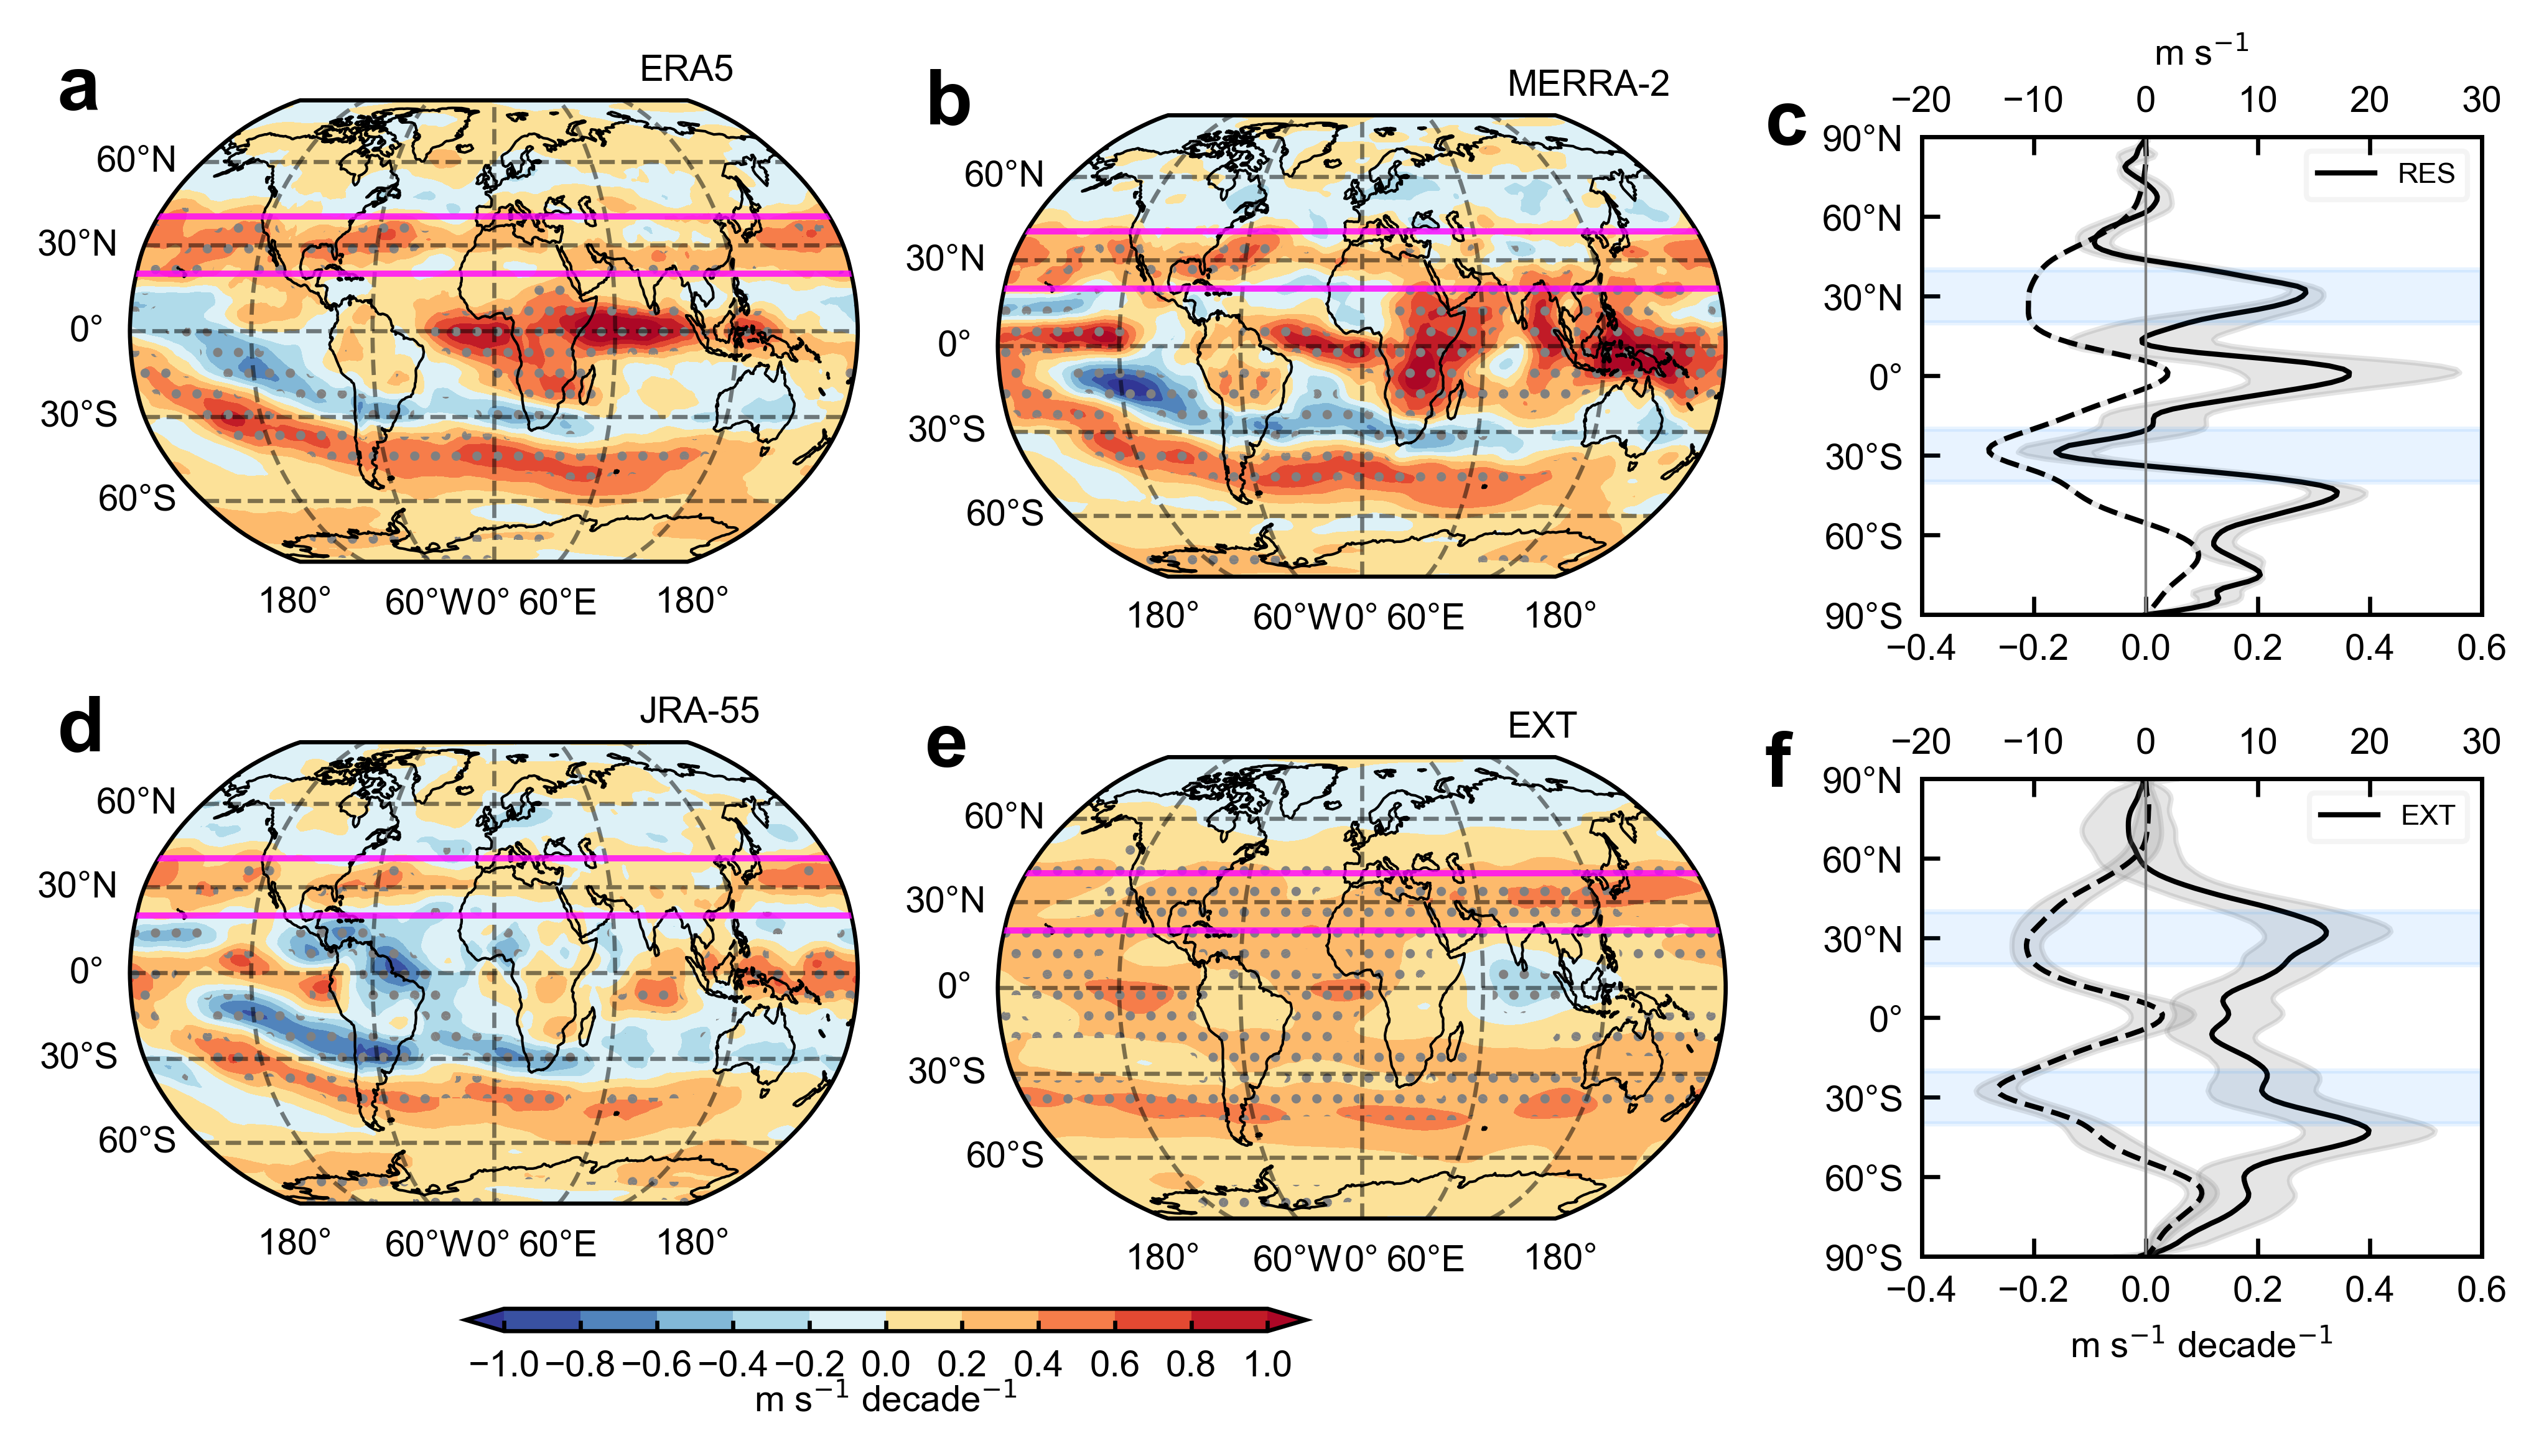

In [21]:
fig = plt.figure(figsize=(7.5,4),dpi=600)
leftlon, rightlon, lowerlat, upperlat = (-180, 181, -90, 90)
levels = np.linspace(-1, 1, 11)
levels2 = np.linspace(-20, 40, 7)
axes_list=[[0.08, 0.57, 0.26, 0.36],[0.39, 0.56, 0.26, 0.36],[0.72, 0.56, 0.2, 0.32],
           [0.08, 0.14, 0.26, 0.36],[0.39, 0.13, 0.26, 0.36],[0.72, 0.13, 0.2, 0.32]]

# ERA5子图########trend*120是为了将单位转换成m/s/decade
cf1 = plot_trend_and_significance(axes_list[0], ERA5[:, 0], era5_trend * 120, era5_p_values,
                                  'u$_{100}$ - u$_{200}$', 'a', 'ERA5', levels, levels2, ccmap,
                                  hzl=True)
# MERRA2子图
cf2 = plot_trend_and_significance(axes_list[1],MERRA2[:, 1], merra2_trend * 120, merra2_p_values,
                                  'u$_{100}$ - u$_{200}$', 'b', 'MERRA-2', levels, levels2, ccmap,
                                  hzl=True)
# JRA55子图
cf3 = plot_trend_and_significance(axes_list[3], JRA55[:, 0], jra55_trend * 120, jra55_p_values,
                                  'u$_{100}$ - u$_{200}$', 'd', 'JRA-55', levels, levels2, ccmap,
                                  hzl=True)
cf4 = plot_trend_and_significance_ssp(axes_list[4],
                                      ssp585[0], h_ssp585_trend * 120, h_ssp585_p_values,
                                      'u$_{100}$ - u$_{200}$', 'e', 'EXT', levels, levels2, ccmap,
                                      hzl=True)
# 添加子图并调整大小
ax5 = fig.add_axes(axes_list[2])  # 调整这些数字以改变大小和位置
ax5_ = ax5.twiny()
ax6 = fig.add_axes(axes_list[5])  # 调整这些数字以改变大小和位置
ax6_ = ax6.twiny()
# ax34.set_xlabel('upward trend (m·s$^{-1}$·decade$^{-1}$)')
# 绘制子图
plot_zonmean_diff(ax6, h_ssp585_trend_zonmean * 120, h_ssp585_trend_zonmean_std,'-', ssp585.lat, 'u$_{100}$ - u$_{200}$',
                  'f',(-0.4, 0.6))
ax6.set_xticks(np.linspace(-.4, .6, 6))
plot_zonmean_diff(ax6_, np.nanmean(h_ssp585_climatology[1]-h_ssp585_climatology[0],1),
                  np.std(h_ssp585_climatology_zonmean_allmodels[:,1]-h_ssp585_climatology_zonmean_allmodels[:,0],axis=0),
                  '--', ssp585.lat, ' ',' ',(-20,30))
ax6_.set_xticks(np.linspace(-20, 30, 6))
ax6.set_xlabel('m s$^{-1}$ decade$^{-1}$', fontsize=7)
ax6.legend(['EXT'],fontsize=5.5,framealpha=0.2,loc='upper right')


###########绘制观测数据#################
era5_zonal_mean, era5_zonal_std = calculate_zonal_stats(era5_trend)
merra2_zonal_mean, merra2_zonal_std = calculate_zonal_stats(merra2_trend)
jra55_zonal_mean, jra55_zonal_std = calculate_zonal_stats(jra55_trend)

# 1. 统一到JRA55的145个纬度点
target_lats = JRA55.g0_lat_2.values
era5_zonal_mean = np.interp(target_lats, ERA5.lat.values, era5_zonal_mean)
merra2_zonal_mean = np.interp(target_lats, MERRA2.lat.values, merra2_zonal_mean)
era5_zonal_mean_clim = np.interp(target_lats, ERA5.lat.values, np.nanmean(ERA5_clim,1))
merra2_zonal_mean_clim = np.interp(target_lats, MERRA2.lat.values, np.nanmean(MERRA2_clim,1))
jra55_zonal_mean_clim = np.nanmean(JRA55_clim,1)
# 2. 合并成一个(3, 145)的数组，计算均值和标准差
all_data = np.stack([era5_zonal_mean, merra2_zonal_mean, jra55_zonal_mean], axis=0)
obs_zonal_mean_vals = np.mean(all_data, axis=0)
obs_zonal_mean_std_vals = np.std(all_data, axis=0)
all_data_clim = np.stack([era5_zonal_mean_clim, merra2_zonal_mean_clim, jra55_zonal_mean_clim], axis=0)
obs_zonal_mean_clim_vals = np.mean(all_data_clim, axis=0)
obs_zonal_mean_clim_std_vals = np.std(all_data_clim, axis=0)
# 3. 绘制集合平均
plot_zonmean_diff(ax5, obs_zonal_mean_vals * 120, obs_zonal_mean_std_vals* 120,'-', JRA55.g0_lat_2, 'u$_{100}$ - u$_{200}$',
                  'c',(-0.4, 0.6))
plot_zonmean_diff(ax5_, obs_zonal_mean_clim_vals,
                  np.zeros_like(obs_zonal_mean_clim_std_vals),
                  '--', JRA55.g0_lat_2, ' ',' ',(-20,30))
ax5.set_xticks(np.linspace(-.4, .6, 6))
ax5_.set_xticks(np.linspace(-20, 30, 6))
ax5_.set_xlabel('m s$^{-1}$', fontsize=7)
ax5.legend(['RES'],fontsize=5.5,framealpha=0.2,loc='upper right')

# 创建一个大的轴，然后将colorbar放在下方
cbar_ax = fig.add_axes([0.2, 0.08, 0.3, 0.015])  # 调整这些数字以改变colorbar的大小和位置
# 创建colorbar
cbar = plt.colorbar(cf1, cax=cbar_ax, orientation='horizontal', pad=0.08, aspect=50, shrink=0.7, extend='both')
cbar.ax.xaxis.set_major_locator(MultipleLocator(0.2))
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='both', which='major', direction='in', length=2, labelsize=7)
cbar.set_label(label='m s$^{-1}$ decade$^{-1}$', fontsize=7,labelpad=0.13)
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/figures/formal_work/obsmme_hist_global_pattern_vertical.svg',format='svg',dpi=1200)
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/figures/formal_work/obsmme_hist_global_pattern_vertical.png',format='png',dpi=600)
plt.show()